In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import LambdaLR
from sklearn.model_selection import train_test_split
import matplotlib
import scipy.stats as sc
import math

### Get data: Open chromatin signals and rna expression derivatives over time

In [2]:
# Read the databases of downregulated (decreasing) cCREs and upregulated (increasing) cCREs

data_down = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/models/input/onetoone/downreg.filtered.merge.ESW.tsv',sep = '\t' )
data_up = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/models/input/onetoone/upreg.filtered.merge.ESW.tsv',sep = '\t' )

data = pd.concat([data_up,data_down], ignore_index=True)
data.drop_duplicates(inplace=True, keep='first', ignore_index = True)
data.head()

,cCRE_id,gene_id,10.5_oc,10.601_oc,10.702_oc,10.803_oc,10.904_oc,11.005_oc,11.106_oc,11.207_oc,...,20.596_rna,20.697_rna,20.798_rna,20.899_rna,21.0_rna,correlation,k_rna,k_oc,region,group
0,EM10D1015674,ENSMUSG00000031138,0.029202,0.031025,0.032947,0.034974,0.037108,0.039353,0.041712,0.044188,...,0.091080,0.090304,0.089525,8.874231e-02,0.087957,0.812168,0.169397,0.661612,forebrain,late_upreg
1,EM10D1048963,ENSMUSG00000026087,0.211646,0.210999,0.210139,0.209071,0.207798,0.206326,0.204660,0.202807,...,0.026389,0.026487,0.026585,2.668306e-02,0.026782,-0.954903,0.036533,0.448572,forebrain,late_upreg
2,EM10D1049003,ENSMUSG00000026085,0.284230,0.281768,0.278750,0.275200,0.271148,0.266624,0.261663,0.256302,...,0.000000,0.000000,0.000000,8.087689e-16,0.000000,0.489944,5.379042,0.644327,forebrain,late_upreg
3,EM10D1051299,ENSMUSG00000041945,0.148644,0.148973,0.149247,0.149464,0.149625,0.149729,0.149776,0.149766,...,0.026929,0.026145,0.025381,2.463787e-02,0.023914,0.995292,0.319238,0.273478,forebrain,late_upreg
4,EM10D1052367,ENSMUSG00000010290,0.199561,0.199106,0.198477,0.197676,0.196705,0.195568,0.194269,0.192812,...,0.000140,0.000131,0.000122,1.143565e-04,0.000107,0.901724,0.656777,0.417333,forebrain,late_upreg


In [3]:
## user needs to choose which model to run:
# positively correlated OC-rna Pairs (OC - open chromatin)
# negatively correalated 

print("which model do you want to run? for positively correlated OC-RNA type pos for negatively correlated type neg")
user_input = input()


print(f'user choice is {user_input}')

if user_input == 'pos':
    data_oc_rna = data[(data.correlation > 0)] 
if user_input == 'neg':
    data_oc_rna = data[(data.correlation < 0)]

#data_posR_posKrna
#data_posR_posKrna.head()
if user_input =='pos' or user_input =='neg':
    print(f'user chose {user_input}')
else:
    print('**** only pos or neg are allowed for model choices, please type again ****')

which model do you want to run? for positively correlated OC-RNA type pos for negatively correlated type neg
pos
user choice is pos
user chose pos


In [4]:
data_oc_rna.head()

,cCRE_id,gene_id,10.5_oc,10.601_oc,10.702_oc,10.803_oc,10.904_oc,11.005_oc,11.106_oc,11.207_oc,...,20.596_rna,20.697_rna,20.798_rna,20.899_rna,21.0_rna,correlation,k_rna,k_oc,region,group
0,EM10D1015674,ENSMUSG00000031138,0.029202,0.031025,0.032947,0.034974,0.037108,0.039353,0.041712,0.044188,...,0.091080,0.090304,0.089525,8.874231e-02,0.087957,0.812168,0.169397,0.661612,forebrain,late_upreg
2,EM10D1049003,ENSMUSG00000026085,0.284230,0.281768,0.278750,0.275200,0.271148,0.266624,0.261663,0.256302,...,0.000000,0.000000,0.000000,8.087689e-16,0.000000,0.489944,5.379042,0.644327,forebrain,late_upreg
3,EM10D1051299,ENSMUSG00000041945,0.148644,0.148973,0.149247,0.149464,0.149625,0.149729,0.149776,0.149766,...,0.026929,0.026145,0.025381,2.463787e-02,0.023914,0.995292,0.319238,0.273478,forebrain,late_upreg
4,EM10D1052367,ENSMUSG00000010290,0.199561,0.199106,0.198477,0.197676,0.196705,0.195568,0.194269,0.192812,...,0.000140,0.000131,0.000122,1.143565e-04,0.000107,0.901724,0.656777,0.417333,forebrain,late_upreg
7,EM10D1058934,ENSMUSG00000038174,0.398576,0.396802,0.393674,0.389235,0.383544,0.376677,0.368722,0.359778,...,0.000107,0.000098,0.000089,8.113068e-05,0.000074,0.992134,0.920697,0.825578,forebrain,early_upreg


In [5]:
## Define: X_data (OC - open chromatin derivative features dc/dt) & 
## y_data (gene expression derivative target dg/dt)

def get_data(data):
    "input: dataframe with positive and negative correlations between oc and rna"
    "output: X_data, y_data for the model"

    #oc
    start_column_x = '10.5_oc'
    end_column_x = '21.0_oc'

    start_column_x = data.columns.get_loc(start_column_x)
    end_column_x = data.columns.get_loc(end_column_x)

    #rna
    start_column_y = '10.5_rna'      
    end_column_y = '21.0_rna'
    start_column_y = data.columns.get_loc(start_column_y)
    end_column_y = data.columns.get_loc(end_column_y)

    oc = data.iloc[:,start_column_x:end_column_x+1]
    rna = data.iloc[:,start_column_y:end_column_y+1]

    X_data = oc.values
    y_data = rna.values
    
    return (X_data, y_data)

In [6]:
X_data_OC_derivatives, y_data_rna_derivatives = get_data(data_oc_rna)

In [8]:
def tensorxy(X_data_OC_derivatives, y_data_rna_derivatives):
    "input: X (oc) and y(rna derivatives) arrays "
    "output: X (oc) and y(rna derivatives) tensors"  
    
    seq_len = 105 ## this is the number of time points


    X_OC_derivatives = X_data_OC_derivatives.reshape(len(X_data_OC_derivatives),1,seq_len)
    X_OC_derivatives = X_data_OC_derivatives.astype(float)


    seq_len_y = 105

    y_rna_derivatives = y_data_rna_derivatives.reshape(len(y_data_rna_derivatives),1,seq_len_y)

    # convert into PyTorch tensors
    
    #X = torch.tensor(X, dtype=torch.float32)
    X_OC_derivatives = torch.tensor(X_OC_derivatives, dtype=torch.float32)

    #y = torch.tensor(y, dtype=torch.float32)
    y_rna_derivatives = torch.tensor(y_rna_derivatives, dtype=torch.float32)
    
   
    return(X_OC_derivatives,y_rna_derivatives)

In [19]:
## Define X (Features) and y (target) as tensors
X1,y1 = tensorxy(X_data_OC_derivatives,y_data_rna_derivatives)

### NN model 

In [10]:
batch_size_train = 4 ## can be changed to improve performance, larger--> runs faster. should be changed in train dataloader as well
batch_size_val = 1 
batch_size_test = 1 

In [11]:
#split the data into training set (80%) and temporary set (20%)

X_train1, X_test1, y_train1, y_test1, train_indexes1, test_indexes1 = train_test_split(X1, y1, np.arange(len(X1)),test_size=0.2, random_state=42)


n_points = 105

X_train1 = X_train1.reshape(-1, 1, n_points) 

X_test1 = X_test1.reshape(-1, 1, n_points) 

X_train1 = X_train1[:,0].reshape(X_train1.size()[0],1,n_points) # for OC feature only

train_dataset1 = TensorDataset(X_train1[:,:,:n_points], y_train1[:,:,:n_points])

train_loader1 = DataLoader(train_dataset1, batch_size=batch_size_train, shuffle=True)

X_test1 = X_test1[:,0].reshape(X_test1.size()[0],1,n_points) # for OC feature only

test_dataset1 = TensorDataset(X_test1[:,:,:n_points], y_test1[:,:,:n_points])

test_loader1 = DataLoader(test_dataset1, batch_size=batch_size_test, shuffle=False)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
num_samples = y1.shape[0]


time_steps = 105
num_features = 1 # set number of features
batch_size = 4  # Define the batch size
loss_train_epoch = []


# Define network architacture to regress time series gene expression derivatives 
#from open chromatin signals
class PolynomialRegression(nn.Module):
    
    def __init__(self, degree, num_features):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # set bias=True for posivitely correlated OC-rna derivative pairs
        # set bias=False for negatively correlated OC-rna derivative pairs 
        self.poly = nn.Linear(num_features, degree, bias=True)
        self.relu = nn.LeakyReLU(0.4,inplace=True)
        self.fc = nn.Linear(degree, 1)
 
        
    def forward(self, x):
        
        batch_size, time_steps, num_features = x.size()
        x_poly = self.poly(x)
        x_poly = x_poly.view(batch_size, time_steps, self.degree)
        x_poly = self.relu(x_poly)  # Apply Leaky ReLU activation
        out = self.fc(x_poly)
        
        return out

# Custom loss function to handle per-sample shape
class PerSampleMSELoss(nn.Module):
    def __init__(self):
        super(PerSampleMSELoss, self).__init__()
    

    def forward(self, input, target): 
        loss = torch.mean((input - target) ** 2, dim=1)  # Calculate the loss along the time_steps dimension
        
        return loss

# Initialize the model
degree = 30

warmup_steps = 1000  # Number of warm-up steps
initial_lr = 0.001  # Initial learning rate (warm-up learning rate)
desired_lr = 0.00001  # Desired learning rate


model = PolynomialRegression(degree, num_features)

# Define loss function and optimizer
criterion = PerSampleMSELoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Create a LambdaLR scheduler for warm-up
warmup_scheduler = LambdaLR(optimizer, lr_lambda=lambda step: step / warmup_steps if step < warmup_steps else 1)

# Training loop
num_epochs = 3000
for epoch in range(num_epochs):
 
    for i, (x_batch, y_batch) in enumerate(train_loader1):
        
        x_batch = x_batch.transpose(1, 2).requires_grad_()   ### mor #### NEED TO BE ADDED##########################
        y_batch = y_batch.transpose(1, 2).requires_grad_() 

        # Forward pass
        y_pred = model(x_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Zero gradients, backward pass, and optimize
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()
        
        # Update the learning rate using the warm-up scheduler
        warmup_scheduler.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.mean().item():.4f}')
        loss_train_epoch.append(loss.mean().item())

Epoch [100/3000], Loss: 0.0058
Epoch [200/3000], Loss: 0.0111
Epoch [300/3000], Loss: 0.0056
Epoch [400/3000], Loss: 0.0084
Epoch [500/3000], Loss: 0.0285
Epoch [600/3000], Loss: 0.0075
Epoch [700/3000], Loss: 0.0091
Epoch [800/3000], Loss: 0.0125
Epoch [900/3000], Loss: 0.0124
Epoch [1000/3000], Loss: 0.0073
Epoch [1100/3000], Loss: 0.0093
Epoch [1200/3000], Loss: 0.0048
Epoch [1300/3000], Loss: 0.0184
Epoch [1400/3000], Loss: 0.0112
Epoch [1500/3000], Loss: 0.0049
Epoch [1600/3000], Loss: 0.0090
Epoch [1700/3000], Loss: 0.0255
Epoch [1800/3000], Loss: 0.0146
Epoch [1900/3000], Loss: 0.0024
Epoch [2000/3000], Loss: 0.0081
Epoch [2100/3000], Loss: 0.0140
Epoch [2200/3000], Loss: 0.0062
Epoch [2300/3000], Loss: 0.0054
Epoch [2400/3000], Loss: 0.0145
Epoch [2500/3000], Loss: 0.0060
Epoch [2600/3000], Loss: 0.0158
Epoch [2700/3000], Loss: 0.0093
Epoch [2800/3000], Loss: 0.0330
Epoch [2900/3000], Loss: 0.0067
Epoch [3000/3000], Loss: 0.0111


In [13]:
## run this cell before loading a Pytorch model

## save model ###  ## to save a Pytorch model use:
#torch.save(model, 'model_name.pth')


class PolynomialRegression(nn.Module):
    def __init__(self, degree, num_features):
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        # set bias=True for posivitely correlated OC-rna derivative pairs
        # set bias=False for negatively correlated OC-rna derivative pairs 
        self.poly = nn.Linear(num_features, degree, bias=False) 
        self.relu = nn.LeakyReLU(0.4,inplace=True)
        self.fc = nn.Linear(degree, 1)
     

    def forward(self, x):
        batch_size, time_steps, num_features = x.size()
        x_poly = self.poly(x)
        x_poly = x_poly.view(batch_size, time_steps, self.degree)
        x_poly = self.relu(x_poly)  # Apply Leaky ReLU activation
        
        
        out = self.fc(x_poly)
        
        return out
    
# Custom loss function to handle per-sample shape
class PerSampleMSELoss(nn.Module):
    def __init__(self):
        super(PerSampleMSELoss, self).__init__()
    
        

    def forward(self, input, target):
        loss = torch.mean((input - target) ** 2, dim=1)  # Calculate the loss along the time_steps dimension
        
        return loss
criterion = PerSampleMSELoss()

Text(0, 0.5, 'Avg. train MSE')

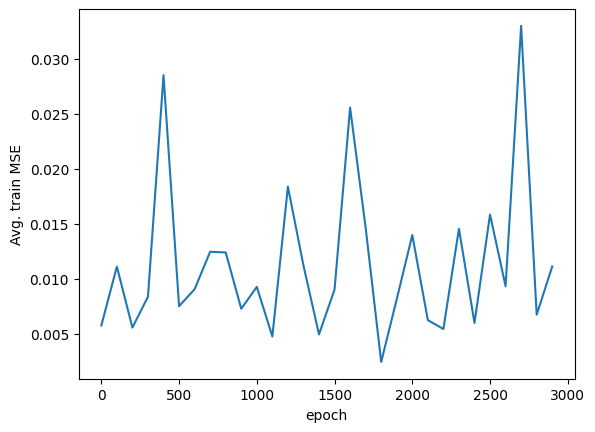

In [14]:
### plot MSE (mean square error for each training epoch)

plt.plot([i for i in range(0,3000,100)],loss_train_epoch)
plt.xlabel('epoch')
plt.ylabel('Avg. train MSE')

In [15]:
# Testing / inference
test_losses = []
all_pred_y = []
all_true_y = []

batch_size_test = 1
with torch.no_grad():
    
    for i, (x_batch, y_batch) in enumerate(test_loader1):
        
        x_batch = x_batch.transpose(1, 2)   
        y_batch = y_batch.transpose(1, 2)
        
        ## run this line if you trained the model
        #y_pred = model(x_batch)
        
        ## run this line to load the model for positively correlated OC-rna derivative pairs
        #model = torch.load('braindev/Model_Positive_OC_rna_corr.pth')
        
        ## run this line to load the model for negatively correlated OC-rna derivative pairs
        #model = torch.load('braindev/Model_Negative_OC_rna_corr.pth')
        
        model.eval()
        y_pred = model(x_batch)
        all_pred_y.append(y_pred)
        all_true_y.append(y_batch)

        # Compute the loss
       
        loss = criterion(y_pred, y_batch)
        print(f'Loss: {loss.mean().item():.4f}')
        test_losses.append(loss.mean().item())

Loss: 0.0022
Loss: 0.0177
Loss: 0.0028
Loss: 0.0072
Loss: 0.0065
Loss: 0.0085
Loss: 0.0135
Loss: 0.0132
Loss: 0.0021
Loss: 0.0086
Loss: 0.0026
Loss: 0.0215
Loss: 0.0190
Loss: 0.0036
Loss: 0.0031
Loss: 0.0179
Loss: 0.0026
Loss: 0.0064
Loss: 0.0011
Loss: 0.0057
Loss: 0.0028
Loss: 0.0019
Loss: 0.0004
Loss: 0.0024
Loss: 0.0118
Loss: 0.0029
Loss: 0.0003
Loss: 0.0067
Loss: 0.0070
Loss: 0.0051
Loss: 0.0032
Loss: 0.0062
Loss: 0.0130
Loss: 0.0028
Loss: 0.0258
Loss: 0.0036
Loss: 0.0204
Loss: 0.0031
Loss: 0.0016
Loss: 0.0011
Loss: 0.0022
Loss: 0.0043
Loss: 0.0015
Loss: 0.0004
Loss: 0.0012
Loss: 0.0026
Loss: 0.0035
Loss: 0.0014
Loss: 0.0009
Loss: 0.0059
Loss: 0.0042
Loss: 0.0032
Loss: 0.0050
Loss: 0.0155
Loss: 0.0019
Loss: 0.0048
Loss: 0.0076
Loss: 0.0099
Loss: 0.0006
Loss: 0.0104
Loss: 0.0065
Loss: 0.0055
Loss: 0.0003
Loss: 0.0035
Loss: 0.0194
Loss: 0.0132
Loss: 0.0043
Loss: 0.0187
Loss: 0.0019
Loss: 0.0028
Loss: 0.0004
Loss: 0.0033
Loss: 0.0008
Loss: 0.0041
Loss: 0.0107
Loss: 0.0025
Loss: 0.0007

Loss: 0.0025
Loss: 0.0015
Loss: 0.0017
Loss: 0.0044
Loss: 0.0107
Loss: 0.0050
Loss: 0.0182
Loss: 0.0067
Loss: 0.0060
Loss: 0.0571
Loss: 0.0069
Loss: 0.0055
Loss: 0.0158
Loss: 0.0144
Loss: 0.0094
Loss: 0.0060
Loss: 0.0033
Loss: 0.0172
Loss: 0.0164
Loss: 0.0124
Loss: 0.0053
Loss: 0.0017
Loss: 0.0182
Loss: 0.0054
Loss: 0.0002
Loss: 0.0003
Loss: 0.0013
Loss: 0.0082
Loss: 0.0160
Loss: 0.0153
Loss: 0.0021
Loss: 0.0100
Loss: 0.0036
Loss: 0.0095
Loss: 0.0094
Loss: 0.0043
Loss: 0.0162
Loss: 0.0126
Loss: 0.0180
Loss: 0.0187
Loss: 0.0046
Loss: 0.0009
Loss: 0.0040
Loss: 0.0030


In [ ]:
# plot true dg/dt versus predicted dg/dt over time

num_points = 105
t = np.linspace(10.5,21,105)

for i in range(0,len(all_true_y)):
    plt.figure(figsize=(4,4))
    plt.scatter(t, all_true_y[i])
    plt.scatter(t, all_pred_y[i])

    
    plt.title(f'{data_oc_rna.iloc[test_indexes1[i],[0]].values.tolist()[0],  data_oc_rna.iloc[test_indexes1[i],[1]].values.tolist()[0]}')
    plt.xlabel('mouse PCDs', fontsize=18)
    plt.ylabel('dg/dt \n (gene expression derivatives)', fontsize=18)
    plt.ylabel('dg/dt', fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlim(10,22)
    plt.legend(['true dg/dt', 
                'predicted dg/dt'], 
               loc='upper center', bbox_to_anchor=(0.65, 1.5),fontsize=15 )

In [31]:
def find_indices(list_to_check, item_to_find):
    "input: list_to_check: list if genes / cCREs ID"
    "Output: item_to_find: gene / cCRE ID that its index needs to be found in list_to_check"
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

gene index [206]
gene id ENSMUSG00000015942
cCRE id EM10D1960585
[0.011742105707526207, 0.013652827590703964, 0.015830570831894875, 0.018305370584130287, 0.02110820822417736, 0.02427014149725437, 0.027821054682135582, 0.03178799897432327, 0.036193083971738815, 0.04105082154273987, 0.04636497050523758, 0.05212495103478432, 0.05830201506614685, 0.06484532356262207, 0.071678526699543, 0.07869716733694077, 0.08576775342226028, 0.09272894263267517, 0.09939564019441605, 0.10556618869304657, 0.11103270202875137, 0.11559396982192993, 0.11906986683607101, 0.12131568044424057, 0.12223447114229202, 0.12178578972816467, 0.11998948454856873, 0.11692371219396591, 0.11271797120571136, 0.10754173249006271, 0.1015905812382698, 0.09507167339324951, 0.08819012343883514, 0.08113771677017212, 0.07408461719751358, 0.06717418134212494, 0.06052088364958763, 0.054210517555475235, 0.048302389681339264, 0.04283243045210838, 0.03781704232096672, 0.03325699269771576, 0.02914109267294407, 0.025449538603425026, 0.02

,cCRE_id,gene_id,10.5_oc,10.601_oc,10.702_oc,10.803_oc,10.904_oc,11.005_oc,11.106_oc,11.207_oc,...,20.596_rna,20.697_rna,20.798_rna,20.899_rna,21.0_rna,correlation,k_rna,k_oc,region,group
5662,EM10D1960585,ENSMUSG00000015942,-0.036398,-0.041905,-0.048181,-0.055314,-0.063392,-0.072505,-0.082739,-0.094172,...,0.000163,0.000148,0.000135,0.000123,0.000112,-0.709738,0.944342,-1.479321,hindbrain,downreg


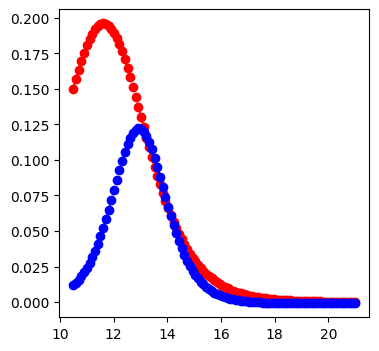

In [33]:
# plot time series data of a specific cCRE along with its associated gene ID

t = np.linspace(10.5,21,105)

## get list of all gene IDs which are in the text set
l = [i[0] for i in data_oc_rna.iloc[test_indexes1[:],[1]].values.tolist()]

## find the index of a specific gene ID
index_gene = find_indices(l, 'ENSMUSG00000015942')[0]
print('gene index', find_indices(l, 'ENSMUSG00000015942'))
geneid = f'{l[index_gene]}'
print('gene id',l[index_gene])

## get list of all cCRE IDs which are in the text set 
c = [i[0] for i in data_oc_rna.iloc[test_indexes1[:],[0]].values.tolist()]
ccreid = f'{c[index_gene]}'
print('cCRE id', c[index_gene])

## plot gene derivative true values versus predicted values
plt.figure(figsize=(4,4))
plt.plot(t, [i[0] for i in all_true_y[index_gene].tolist()[0]],'--ro')
plt.plot(t, [i[0] for i in all_pred_y[index_gene].tolist()[0]], '--bo')

## print predicted gene derivatives
print([i[0] for i in all_pred_y[index_gene][0].tolist()])


print('first rna derivative value',data_oc_rna[(data_oc_rna['cCRE_id']==f'{c[index_gene]}') & (data_oc_rna['gene_id']==f'{l[index_gene]}')].loc[:,'10.5_rna'].tolist())
data_oc_rna[(data_oc_rna['cCRE_id']==f'{c[index_gene]}') & (data_oc_rna['gene_id']==f'{l[index_gene]}')]

### Euler

In [36]:
def euler(t_prev,y_prev, deriv_prev,t_next):
    "apply the Euler method"
    "input: t_prev: previous time point (t_n) ,y_prev: previous gene / cCRE value"
    "deriv_prev: derivative at time t_n, t_next: the next time point (t_n+1)"
    
    y_next = y_prev + deriv_prev*(t_next - t_prev)
    
    return y_next

In [39]:
def run_euler(initial_point, all_y_pred):
    "run the Euler method"
    "input: initial point: real value of gene expression"
    "all_y_pred: gene expression at all time points"
     
    t = np.linspace(10.5,21,105)
    n = 0
    constructed_line = []
    y=initial_point  ## initial point is the real point
    y0=[initial_point]

    for i in range(0,105):
      
        y_pred = all_y_pred[n]
        t_prev = t[n]
        y_prev = y
        deriv_prev = y_pred
        if n+1==105:
            break
        t_next = t[n+1]
        y = euler(t_prev,y_prev, deriv_prev, t_next)
        constructed_line.append(y)
        n = n+1
    constructed_line = y0+constructed_line 
    return constructed_line

In [42]:
# get parameters to run the Euler method

rna_actual_pipe = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/ODE/rna/values/forebrain.jan8.tsv',sep = '\t' )
real_values_geneid = geneid
index_geneid = rna_actual_pipe[rna_actual_pipe['gene_id']== f'{real_values_geneid}'].index[0]
initial_real_value_gene =  rna_actual_pipe.iloc[index_geneid,1]

In [44]:
### run euler for the NN

rna_actual_pipe = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/ODE/rna/values/forebrain.jan8.tsv',sep = '\t' )
real_values_geneid = geneid
index_geneid = rna_actual_pipe[rna_actual_pipe['gene_id']== f'{real_values_geneid}'].index[0]
initial_real_value_gene =  rna_actual_pipe.iloc[index_geneid,1]

all_y_pred = all_pred_y[index_gene].tolist()[0] 
all_y_pred = [i[0]for i in all_y_pred]
constructed_line = run_euler(initial_real_value_gene, all_y_pred)

In [45]:
## run euler for the RF

rna_actual_pipe = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/ODE/rna/values/forebrain.jan8.tsv',sep = '\t' )
real_values_geneid = geneid
index_geneid = rna_actual_pipe[rna_actual_pipe['gene_id']== f'{real_values_geneid}'].index[0]
initial_real_value_gene =  rna_actual_pipe.iloc[index_geneid,1]

RF_pred_data = pd.read_csv('rf_predictions_samples.tsv', sep = '\t')
#RF_pred = RF_pred_data.iloc[4,1:-1].tolist()  ### put the row number
RF_pred = RF_pred_data[RF_pred_data['gene_id'] == geneid].iloc[0,1:-1].values.tolist()
constructed_line = run_euler(initial_real_value_gene, RF_pred)

In [46]:
RF_pred_data.head(6)

,combined_index,0,1,2,3,4,5,6,7,8,...,96,97,98,99,100,101,102,103,104,gene_id
150,ENSMUSG00000021116-hindbrain-EM10D2410214,-0.161860,-0.158411,-0.155075,-0.151850,-0.148734,-0.145725,-0.142821,-0.140019,-0.137317,...,-0.030872,-0.030434,-0.030003,-0.029579,-0.029162,-0.028751,-0.028347,-0.027950,-0.027559,ENSMUSG00000021116
151,ENSMUSG00000018547-forebrain-EM10D1257042,0.265936,0.262789,0.259120,0.255019,0.250556,0.245786,0.240754,0.235491,0.230024,...,0.000238,0.000549,0.000866,0.001177,0.001472,0.001746,0.001995,0.002215,0.002407,ENSMUSG00000018547
207,ENSMUSG00000015942-hindbrain-EM10D1960585,0.204310,0.190550,0.182799,0.177225,0.172527,0.168328,0.164520,0.161061,0.157924,...,0.023644,0.023070,0.022507,0.021957,0.021418,0.020891,0.020376,0.019872,0.019379,ENSMUSG00000015942
1,ENSMUSG00000039703-forebrain-EM10D3074493,-0.262532,-0.254782,-0.247350,-0.240223,-0.233389,-0.226833,-0.220545,-0.214512,-0.208723,...,-0.019265,-0.018770,-0.018289,-0.017820,-0.017363,-0.016917,-0.016484,-0.016061,-0.015650,ENSMUSG00000039703
282,ENSMUSG00000047884-forebrain-EM10D3348506,0.415691,0.348046,0.302372,0.271796,0.245767,0.221147,0.197500,0.175059,0.154133,...,-0.020248,-0.020252,-0.020249,-0.020241,-0.020228,-0.020210,-0.020187,-0.020160,-0.020129,ENSMUSG00000047884
293,ENSMUSG00000078765-forebrain-EM10D2861964,0.151455,0.104378,0.082656,0.072047,0.064413,0.058180,0.052869,0.048228,0.044102,...,-0.148587,-0.135691,-0.122840,-0.110322,-0.098362,-0.087123,-0.076710,-0.067177,-0.058541,ENSMUSG00000078765


cCRE id EM10D1960585
gene id ENSMUSG00000015942 

true values [0.1717377320953133, 0.1990835873152051, 0.2291550973127236, 0.261737718407741, 0.2964794100270397, 0.3328954234706728, 0.3703889040064909, 0.4082866172787357, 0.4458858191014444, 0.4825056022446458, 0.5175349212832677, 0.5504703397171652, 0.5809390464464285, 0.6087059580178005, 0.6336667198017343, 0.6558303936108016, 0.6752963239205915, 0.6922293093849664, 0.7068362028753551, 0.7193458643494862, 0.7299933136734321, 0.7390081319250174, 0.7466066672053895, 0.752987366589688, 0.7583285037145568, 0.7627876282955932, 0.7665021726044546, 0.7695907727094805, 0.7721549774241248, 0.7742811153612992, 0.7760421674782829, 0.7774995501973415, 0.77870475554455, 0.7797008231671401, 0.7805236377570419, 0.7812030570148776, 0.7817638819590701, 0.7822266847212676, 0.7826085101375935, 0.7829234672678876, 0.783183226016417, 0.7833974326637142, 0.7835740565930787, 0.7837196789572797, 0.7838397325691133, 0.7839387009603639, 0.7840202833576101, 0.

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

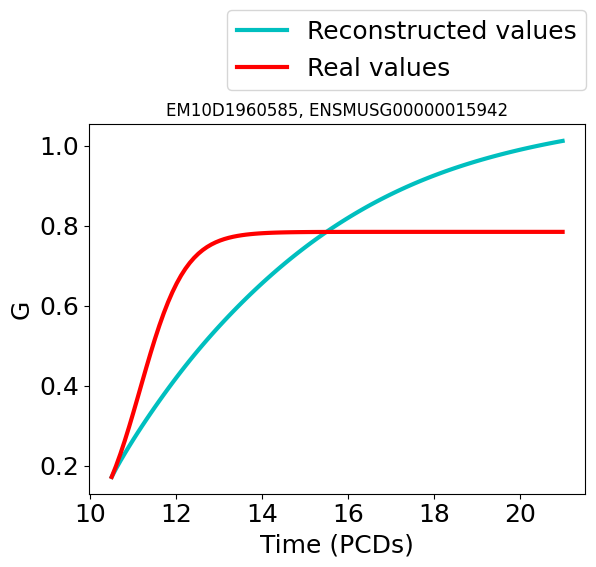

In [47]:
## plot euler

rna_actual_pipe = pd.read_csv('/gpfs/gibbs/pi/gerstein/bb.shared.projects/brain-comp-dev/analyses/mouse/ODE/rna/values/forebrain.jan8.tsv',sep = '\t' )

real_values_geneid = geneid 
index_geneid = rna_actual_pipe[rna_actual_pipe['gene_id']== f'{real_values_geneid}'].index[0]
real_values_gene =  rna_actual_pipe.iloc[index_geneid,1:]

print('cCRE id', ccreid)
print('gene id', real_values_geneid, '\n')
print('true values', real_values_gene.tolist(), '\n')
print('reconstructed values', constructed_line[0:105], '\n')

plt.plot(t[0:105], constructed_line[0:105], linewidth=3, c='c')
plt.plot(t[0:105],real_values_gene.tolist()[0:105], linewidth=3, c='r')

plt.legend(['Reconstructed values', 'Real values'], fontsize=18, 
           bbox_to_anchor=(0.64, 1.2), loc='center')
plt.title(f'{ccreid}, {geneid}') 
plt.xlabel('Time (PCDs)', fontsize=18)
plt.ylabel('G', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

### NN performance: Pearson's r and MAE (mean absolute error)

0.9541612870973647
0.8049983214694311
0.4672722565106473
0.6939417055094202
0.2998792401963475
positive corr 1.0


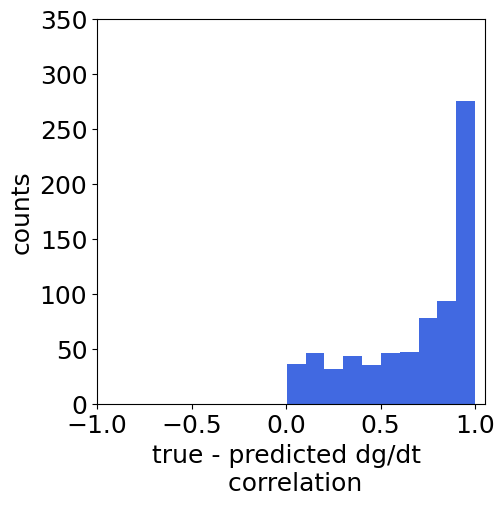

In [17]:
## plot true-predicted correlation histogram

corr_list = []
true_list = []
pred_list = []

for i in range(0, len(all_true_y)):
    true_list.append([i[0] for i in all_true_y[i][0].tolist()])
    pred_list.append([i[0] for i in all_pred_y[i][0].tolist()])

for i in range(0, len(pred_list)):
    r,p = sc.pearsonr(pred_list[i], true_list[i])
    corr_list.append(r)

corr_list = [0 if math.isnan(x) else x for x in corr_list]
plt.figure(figsize=(5,5))
plt.hist(corr_list, histtype = 'stepfilled', color='royalblue')
plt.xticks(fontsize=18)
plt.xlabel('true - predicted dg/dt \n correlation', fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('counts', fontsize=18)
plt.ylim(0,350)
#plt.xlim(-0.1,1)
plt.xticks([-1,-0.5, 0, 0.5, 1])
#plt.yticks([0, 100])
print(np.nanpercentile(corr_list, 75))
print(np.nanpercentile(corr_list, 50))
print(np.nanpercentile(corr_list, 25)) 

print(np.mean(corr_list))
print(np.std(corr_list))
print('positive corr', len([i for i in corr_list if i>0])/len(corr_list))


0.06404386516508445
0.08327087418712445


Text(0, 0.5, 'counts')

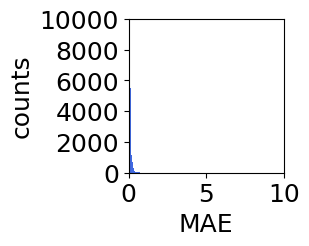

In [50]:
## calculate mean and std of MAE
plt.figure(figsize=(2,2))

#MAE_list = []
MAE_all_list = []

    
MAE_list = [np.absolute(i) for i in np.subtract(true_list,pred_list)]      
for k in MAE_list:
    MAE_all_list.extend(k)
print(np.mean(np.array(MAE_all_list)))
print(np.std(np.array(MAE_all_list)))
plt.hist(MAE_all_list, bins=60, color='royalblue')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,10)
plt.ylim(0,10000)
plt.xlabel('MAE', fontsize=18)
plt.ylabel('counts', fontsize=18)

### Cross validation

In [22]:
def my_folds(train_data,my_fold):
    "divide the train data into 5 folds"
    "input: train data & requested fold" 
    "output: train and test indexes for a requested fold"

    from sklearn.model_selection import KFold


    kf = KFold(n_splits=5, random_state=None, shuffle=False)

    for i, (train_index, test_index) in enumerate(kf.split(train_data)):
        #print(f"Fold {i}:")
        #print(f"  Train: index={train_index}")
        #print(f"  Test:  index={test_index}")
        if i ==my_fold:
            train_index_, test_index_ = train_index, test_index
            break
 
    return train_index_, test_index_

In [26]:
## Perform cross validation on the train set only
## find the indexes to devide the train set into train-test subset, then run train and test the model

train_index_0, test_index_0 = my_folds(train_indexes1, 0)
train_index_1, test_index_1 = my_folds(train_indexes1, 1)
train_index_2, test_index_2 = my_folds(train_indexes1, 2)
train_index_3, test_index_3 = my_folds(train_indexes1, 3)
train_index_4, test_index_4 = my_folds(train_indexes1, 4)

In [99]:
#### cross validation - folds NN versus RF ####
import pandas as pd


def folds_NN_RF(NN_mean, RF_mean, NN_std, RF_std, title, ylabel):

    plotdata = pd.DataFrame({

        "NN":NN_mean,

        "RF":RF_mean,

        },

        index=["Fold0", "Fold1", "Fold2", "Fold3", "Fold4"])

    if ylabel == "Pearson's r":
        plotdata.plot(kind="bar",figsize=(3, 3), rot=25, fontsize=13, yerr=[NN_std, RF_std], capsize=6,
                 color=['cornflowerblue', 'mediumseagreen'])
        
    if ylabel == 'MAE':
        
        plotdata.plot(kind="bar",figsize=(3, 3), rot=25, fontsize=13, yerr=[NN_std, RF_std], capsize=6,
                 color=['cornflowerblue', 'mediumseagreen'], 
                      error_kw=dict(ecolor='black',elinewidth=2, lolims=True, capsize=0.0001))
        plt.ylim(0,0.15)
    
    #plt.xlabel("Model", fontsize=15)

    plt.ylabel(f'{ylabel}', fontsize=15)
    #plt.ylabel("MAE", fontsize=15)

    plt.legend(fontsize=14, bbox_to_anchor=(-0.05, 1.6), loc='upper left')

    #plt.ylim(0,1.1)
    
    plt.title(f'{title}')
    plt.ylabel(f'{ylabel}')

    #plt.savefig("braindev/corr.svg", format="svg", bbox_inches="tight",dpi=300)
    
    return

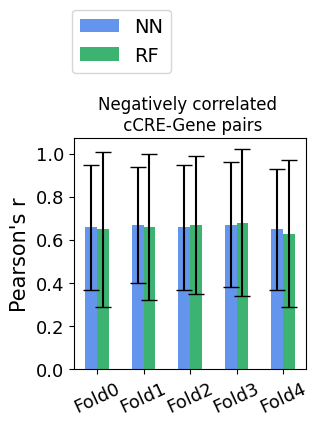

In [100]:
### run Pearson r correlation ###


NN_corr_mean_poss = [0.72, 0.72, 0.71, 0.65, 0.69]
RF_corr_mean_poss = [0.7, 0.71, 0.69, 0.67, 0.69]

NN_corr_std_poss = [0.28, 0.28, 0.28,0.3, 0.31]
RF_corr_std_poss = [0.33, 0.32, 0.32, 0.34, 0.34]

NN_corr_mean_neg = [0.66, 0.67, 0.66, 0.67, 0.65]
RF_corr_mean_neg = [0.65, 0.66, 0.67, 0.68, 0.63]

NN_corr_std_neg = [0.29, 0.27, 0.29, 0.29, 0.28]
RF_corr_std_neg = [0.36, 0.34, 0.32, 0.34, 0.34]


### run cross validation correlation. Choose between positively/negatively correlated CO-RNA derivatives
#folds_NN_RF(NN_corr_mean_poss, RF_corr_mean_poss, NN_corr_std_poss, RF_corr_std_poss,'Positively correlated \n cCRE-Gene pairs',"Pearson's r")
folds_NN_RF(NN_corr_mean_neg, RF_corr_mean_neg, NN_corr_std_neg, RF_corr_std_neg,'Negatively correlated \n cCRE-Gene pairs',"Pearson's r")

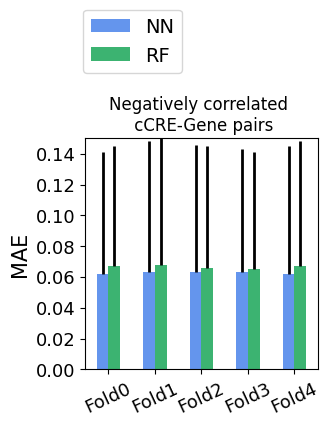

In [102]:
### MAE###
NN_MAE_mean_poss = [0.061, 0.065, 0.062, 0.064, 0.060]
RF_MAE_mean_poss = [0.066, 0.066, 0.066, 0.069, 0.067]

NN_MAE_std_poss = [0.075, 0.074, 0.077, 0.076, 0.079]
RF_MAE_std_poss = [0.075, 0.076, 0.078, 0.077, 0.08]

NN_MAE_mean_neg = [0.062, 0.063, 0.063, 0.063, 0.062]
RF_MAE_mean_neg = [0.067, 0.068, 0.066, 0.065, 0.067]

NN_MAE_std_neg = [0.079, 0.085, 0.083, 0.080, 0.083]
RF_MAE_std_neg = [0.078, 0.083, 0.079, 0.076, 0.081]


### run cross validation MAE
#folds_NN_RF(NN_MAE_mean_poss, RF_MAE_mean_poss, NN_MAE_std_poss, RF_MAE_std_poss, 'Positively correlated \n cCRE-Gene pairs',"MAE")
folds_NN_RF(NN_MAE_mean_neg, RF_MAE_mean_neg, NN_MAE_std_neg, RF_MAE_std_neg, 'Negatively correlated \n cCRE-Gene pairs',"MAE" )

### Performance on the test set

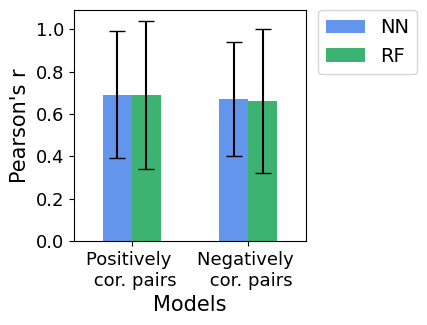

In [84]:
#### test set NN versus RF correlation####
import pandas as pd

plotdata = pd.DataFrame({

    "NN":[0.69, 0.67],

    "RF":[0.69,0.66],

    },

    index=["Positively \n cor. pairs", "Negatively \n cor. pairs"])

plotdata.plot(kind="bar",figsize=(3, 3), rot=0, fontsize=13, yerr=[[0.3, 0.27], [0.35, 0.34]], capsize=6,
             color=['cornflowerblue', 'mediumseagreen'], legend=False)

plt.xlabel("Models", fontsize=15)

plt.ylabel("Pearson's r", fontsize=15)


#plt.ylim(0,3.5)

#plt.legend(fontsize=14, loc='upper left')
#plt.savefig("braindev/paper_fig_pack/correlations_test_new_table.pdf", format="pdf", bbox_inches="tight",dpi=300)
plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1.04), loc='upper left')

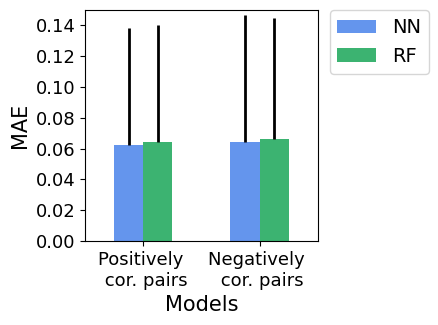

In [88]:
#### test set NN versus RF MAE####
import pandas as pd

plotdata = pd.DataFrame({

    "NN":[0.062, 0.064],

    "RF":[0.064, 0.066],

    },

    index=["Positively \n cor. pairs", "Negatively \n cor. pairs"])

plotdata.plot(kind="bar",figsize=(3, 3), rot=0, fontsize=13, yerr=[[0.076, 0.083], [0.076, 0.079]],capsize=0.5,
             color=['cornflowerblue', 'mediumseagreen'], legend=False,
             error_kw=dict(ecolor='black',elinewidth=2, lolims=True, capsize=0.0001))

plt.xlabel("Models", fontsize=15)
plt.ylabel("MAE", fontsize=15)
plt.ylim(0,0.150)


plt.legend(fontsize=14, bbox_to_anchor=(1.01, 1.04), loc='upper left')